## Part 2: ML Pipeline

## 1. Settings and imports

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from pathlib import Path

In [11]:
class CF:

    def __init__(self):
        self.dataset = Path("ST001906_1.csv")

        if not self.dataset.exists():
            raise FileNotFoundError(f"Dataset {self.dataset} not found.")

In [12]:
df = pd.read_csv(CF().dataset)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 80 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     61 non-null     object 
 1   Class                  61 non-null     int64  
 2   1,5-Anhydroglucitol    61 non-null     float64
 3   2-Aminobutyrate        61 non-null     float64
 4   2-Hydroxybutyrate      61 non-null     float64
 5   3-Aminoisobutyrate     61 non-null     float64
 6   3-Hydroxybutyrate      61 non-null     float64
 7   Alanine                61 non-null     float64
 8   Allose                 60 non-null     float64
 9   alpha-Tocopherol       61 non-null     float64
 10  Arabinose              61 non-null     float64
 11  Arginine               61 non-null     float64
 12  Asparagine             61 non-null     float64
 13  Aspartate              61 non-null     float64
 14  beta-Alanine           61 non-null     float64
 15  Choleste

In [13]:
# Define target and features variables
y = df["Class"]
X = df.drop(columns=["Class", "ID"])

In [14]:
# Define the ML pipeline
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(penalty="elasticnet",
                                      solver="saga",
                                      max_iter=10000,))
])

# Define the hyperparameter grid
param_grid = {
    "classifier__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
    "classifier__C": [0.01, 0.1, 1, 10],
}

In [15]:
# Define cross-validation strategy for hyperparamiter tuning and model evaluation

# Inner CV: For hyperparameter tuning using GridSearch
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Outer CV: For model evaluation
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store all results
all_y_true = []
all_y_pred = []
all_y_prob = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Define GridSearchCV object
    grid_search = GridSearchCV(estimator=pipeline, 
                            param_grid=param_grid, 
                            cv=inner_cv, 
                            scoring="roc_auc", 
                            n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Save predictions
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)

# Final confusion matrix and classification report
cm = confusion_matrix(all_y_true, all_y_pred)
report = classification_report(all_y_true, all_y_pred, digits=3)
auc = roc_auc_score(all_y_true, all_y_prob)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
print(f"Overall ROC AUC: {auc:.3f}")

Confusion Matrix:
 [[26  4]
 [ 1 30]]

Classification Report:
               precision    recall  f1-score   support

           0      0.963     0.867     0.912        30
           1      0.882     0.968     0.923        31

    accuracy                          0.918        61
   macro avg      0.923     0.917     0.918        61
weighted avg      0.922     0.918     0.918        61

Overall ROC AUC: 0.969


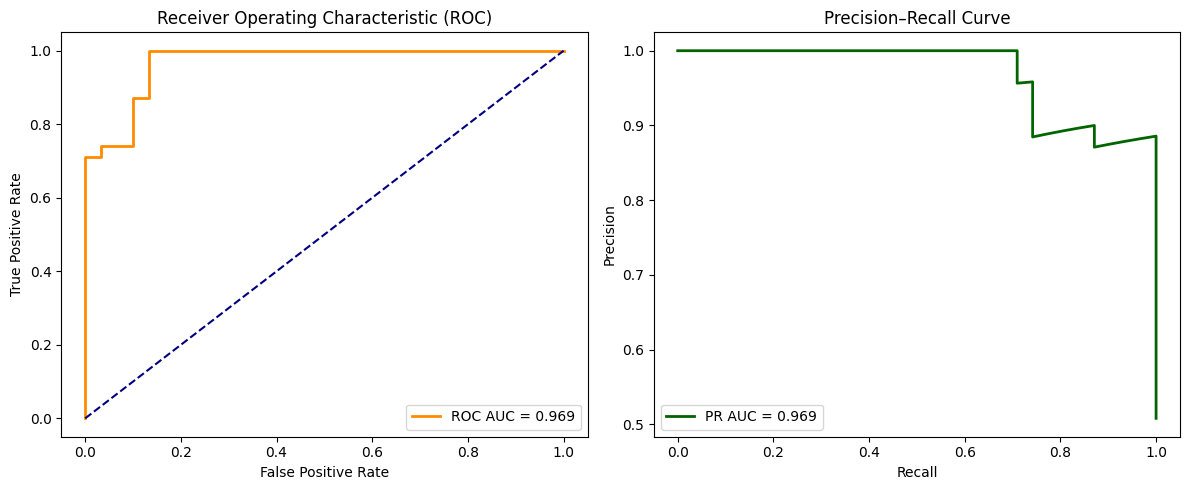

In [17]:
# ROC Curve 
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)     # False Positive Rate, True Positive Rate
roc_auc = auc(fpr, tpr)

# PR Curve
precision, recall, _ = precision_recall_curve(all_y_true, all_y_prob)
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(12, 5))

# ROC plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# PR plot
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkgreen', lw=2, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()